In [1]:
import pygplates
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
sys.path.append('/Users/Simon/GIT/pygplates-citcom/utils/')
from section_plotting import create_profile_points

import paleogeography as pg


%matplotlib inline



basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma'

time = 255.

sampling = 0.5

rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % basedir,
                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % basedir])

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,time)



#####################################
MODELDIR = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/'
RotFile_List = ['%s/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' % MODELDIR]
GPML_List = ['%s/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz' % MODELDIR,\
             '%s/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz' % MODELDIR,\
             '%s/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz' % MODELDIR]
#####################################
rotation_model = pygplates.RotationModel(RotFile_List)
topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)

resolved_topologies = []
shared_boundary_sections = []
pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)
##################################### 



In [2]:
# rasterise points using default environment list 
pg_points = pg.rasterise_paleogeography(pg_dir,rotation_model,time,sampling=sampling)



['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_255Ma/lm_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/PresentDay_Paleogeog_Matthews2016_410-2Ma/PresentDay_Paleogeog_Matthews2016_255Ma/sm_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
[]
no features of type i


In [3]:
deep_ocean_features = []
for feature in pg_points:
    if feature.get_shapefile_attribute('Layer') is None:
        deep_ocean_features.append(feature)

pdepth_points = pg.paleobathymetry_from_topologies(resolved_topologies,
                                                   shared_boundary_sections,
                                                   deep_ocean_features)


Generating distances for Plate 430 ...
Generating distances for Plate 9010 ...
Generating distances for Plate 9009 ...
Generating distances for Plate 604 ...
Generating distances for Plate 902009 ...
Generating distances for Plate 902013 ...
Generating distances for Plate 9014 ...
Generating distances for Plate 601 ...
Generating distances for Plate 602 ...
Generating distances for Plate 701 ...
Generating distances for Plate 580 ...
Generating distances for Plate 505 ...
Generating distances for Plate 926 ...
Generating distances for Plate 902 ...
Generating distances for Plate 16111 ...
Generating distances for Plate 6022 ...
Generating distances for Plate 919 ...
Generating distances for Plate 176 ...


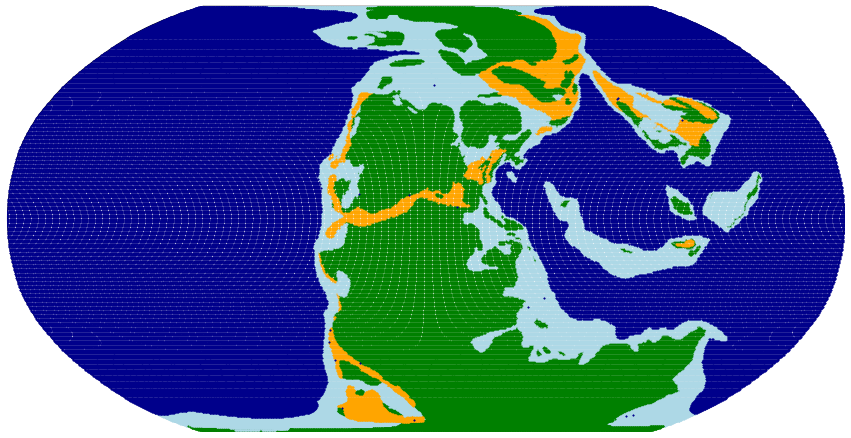

In [4]:
env_color_dict = {'lm':'green',
                  'm':'orange',
                  'sm':'lightblue',
                  'i':'blue'}

plt.figure(figsize=(15,8))

m = pg.paleogeography_points_basemap(pg_points,env_color_dict,fill_color='darkblue',markersize=3)

plt.show()


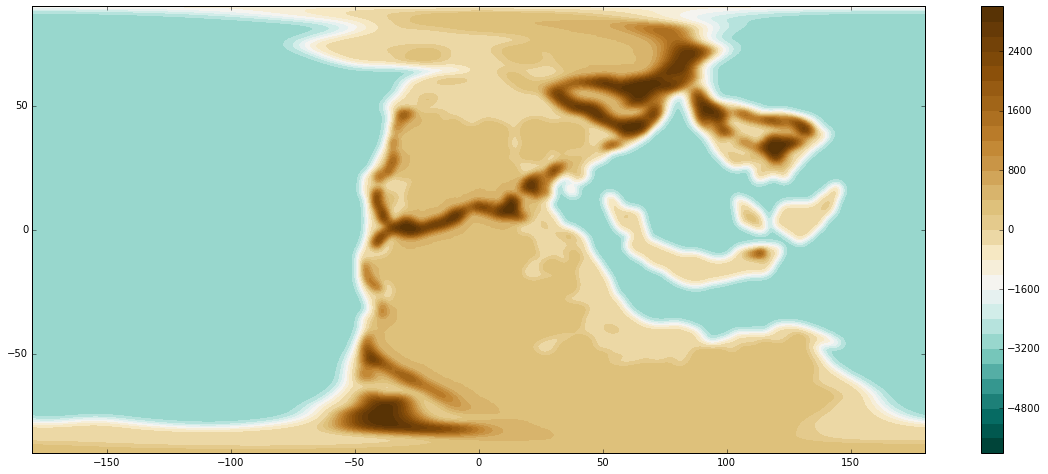

In [22]:
topo_dict = {'lm':400.,
             'm':3000.,
             'sm':-200.,
             'i':500.}

# create a grid from the paleogeography points, mapping height values to each
# point based on the environment and the dictionary specified above

bathymetry_mode = 'fill'

if bathymetry_mode is 'fill':
    # Fill all values in deep ocean with constant
    pg.paleogeography2topography_xyz(pg_points,topo_dict,sampling,
                                     fill_value=-3000,grdfile='test.nc')

elif bathymetry_mode is 'infer':
    # Fill all values in deep ocean with proxy depth from distance to ridges 
    pg.paleogeography2topography_xyz(pg_points,topo_dict,sampling,
                                     bathymetry_points=pdepth_points,grdfile='test.nc')


# optinally perform some smoothing to remove sharp discontinuities at each 
# environment boundary
pg.smooth_topography_grid('test.nc','test_filt.nc',1000.)


gridX,gridY,gridZ = pg.load_netcdf('test_filt.nc')
#gridX,gridY,gridZ = pg.load_netcdf('test.nc')


plt.figure(figsize=(20,8))
plt.contourf(gridX,gridY,gridZ,
             levels=np.hstack((np.arange(-6000,1,400),np.arange(200,3001,200))),
             cmap=plt.cm.BrBG_r)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()


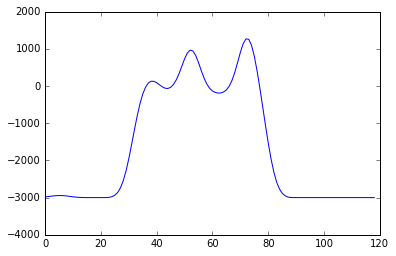

In [27]:
# Specify points for profile

#PtLons = [-86,-35]
#PtLats = [0,0] 

PtLons = [100,130]
PtLats = [10,65]

# derive a great-circle profile lines from the anchor points
GreatCirclePoints,ProfilePoints,arc_distance = create_profile_points(PtLons,PtLats)

# create an array of distances along profile in km, starting at zero
ProfileX_kms = np.arange(0,ProfilePoints.shape[0])*arc_distance

# extract the values from the (smoothed) topography grid along the profile
topo_profile = pg.create_slice(gridX,gridY,gridZ,GreatCirclePoints,ProfilePoints)

plt.plot(topo_profile)


In [28]:
# generate a pygplates polyline feature from the densely sampled great-circle points
cross_section_geometry = pygplates.PolylineOnSphere(GreatCirclePoints)

# Find where the profile line intersects plate boundaries from the resolved topologies
# [TODO - maybe would be better to use the untesselated line segments for this??]
(subduction_intersections,
 ridge_intersections,
 other_intersections) = pg.plate_boundary_intersections(cross_section_geometry,shared_boundary_sections,ProfileX_kms)

print 'Profile crosses: \n%d subduction zones \n%d Mid-ocean ridges \n%d other boundaries' \
    % (len(subduction_intersections), len(ridge_intersections), len(other_intersections))


Profile crosses: 
4 subduction zones 
0 Mid-ocean ridges 
0 other boundaries


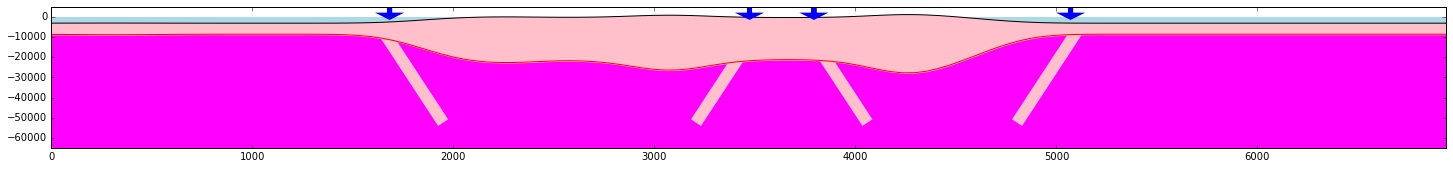

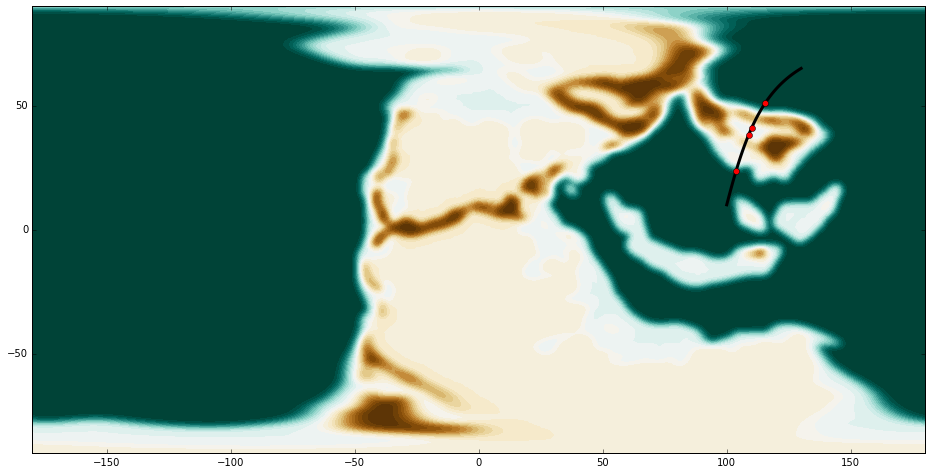

In [29]:
def paleogeography_cross_section(ProfileX_kms,topo_profile,moho_profile,
                                 subduction_intersections,ridge_intersections,
                                 vertical_exaggeration=20.):
    
    plt.plot(ProfileX_kms,topo_profile,'k')
    plt.plot(ProfileX_kms,moho_profile,'r')
    #plt.plot([0,ProfileX_kms[-1]],[0,0],'lightblue',linewidth=3,zorder=1)

    plt.fill_between(ProfileX_kms,topo_profile,moho_profile,color='pink',zorder=2)
    plt.fill_between(ProfileX_kms,0,-7000,color='lightblue')
    plt.fill_between(ProfileX_kms,-7000,-1e7,color='magenta')

    for point in subduction_intersections:
        plt.arrow(point[1],5000, 0.0, -4000, fc="b", ec="b",head_width=40, head_length=1000, linewidth=5,zorder=2)
        if point[2]:
            plt.plot([point[1]+25,point[1]-250],[-8000,-50000],linewidth=12,color='pink',zorder=1)
        else:
            plt.plot([point[1]-25,point[1]+250],[-8000,-50000],linewidth=12,color='pink',zorder=1)
    for point in ridge_intersections:
        plt.arrow(point[1],5000, 0.0, -4000, fc="r", ec="r",head_width=40, head_length=1000, linewidth=5,zorder=2)
    plt.gca().axis('tight')
    plt.gca().set_aspect(vertical_exaggeration/1000.)  # 1000 because intended units are km for distance, but meters for depth
    plt.ylim(-65000,5000)

    
# Get Moho from topography assuming isostasy
moho_profile = pg.topo2moho(topo_profile,ref_depth=22000)

# plot the profile
plt.figure(figsize=(25,3))
paleogeography_cross_section(ProfileX_kms,topo_profile,moho_profile,
                             subduction_intersections,ridge_intersections,
                             vertical_exaggeration=10.)
plt.show()



plt.figure(figsize=(20,8))
plt.contourf(gridX,gridY,gridZ,np.arange(-3000,3001,200),cmap=plt.cm.BrBG_r)
plt.gca().set_aspect('equal')
plt.plot(GreatCirclePoints[:,1],GreatCirclePoints[:,0],'k',linewidth=3)
for point in subduction_intersections:
    plt.plot(point[0].to_lat_lon()[1],point[0].to_lat_lon()[0],'ro')
for point in ridge_intersections:
    plt.plot(point[0].to_lat_lon()[1],point[0].to_lat_lon()[0],'yo')
for point in other_intersections:
    plt.plot(point[0].to_lat_lon()[1],point[0].to_lat_lon()[0],'go')
plt.show()



In [26]:
print subduction_intersections


[[<pygplates.PointOnSphere object at 0x1191803d0>, 4309.9284254882987, False]]
